In [1]:
import requests
import torch
from PIL import Image
from io import BytesIO

import matplotlib.pyplot as plt
from diffusers import StableDiffusionImg2ImgPipeline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\mgphy\anaconda3\envs\genai\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_id_or_path = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id_or_path, torch_dtype=torch.float16)
pipe = pipe.to(device)

url = "https://raw.githubusercontent.com/CompVis/stable-diffusion/main/assets/stable-samples/img2img/sketch-mountains-input.jpg"

response = requests.get(url)
init_image = Image.open(BytesIO(response.content)).convert("RGB")
init_image = init_image.resize((768, 512))

prompt = "" #"A fantasy landscape, trending on artstation"

images = pipe(prompt=prompt, image=init_image, strength=0.75, guidance_scale=7.5).images
# images[0].save("fantasy_landscape.png")

Loading pipeline components...: 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]
c:\Users\mgphy\anaconda3\envs\genai\lib\site-packages\diffusers\models\attention_processor.py:1279: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  hidden_states = F.scaled_dot_product_attention(
100%|██████████| 37/37 [00:12<00:00,  3.01it/s]


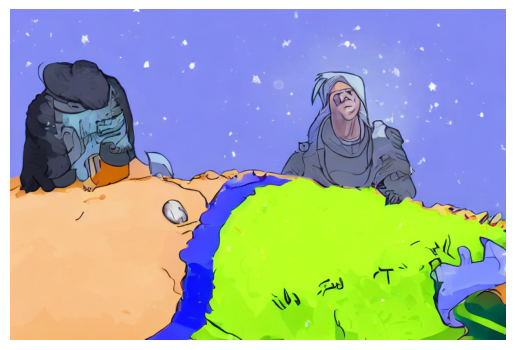

In [3]:
# Assuming you have a list of images called 'images'
for image in images:
    plt.imshow(image)
    plt.axis('off')
    plt.show()

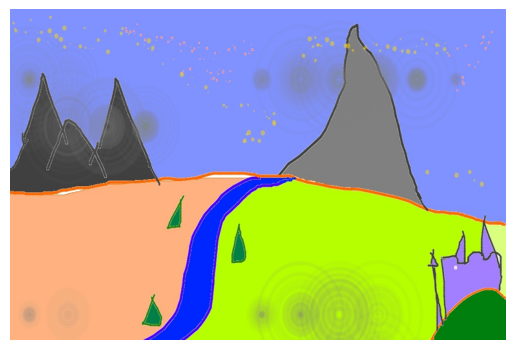

In [4]:
plt.imshow(init_image)
plt.axis('off')
plt.show()

In [5]:
pipe

StableDiffusionImg2ImgPipeline {
  "_class_name": "StableDiffusionImg2ImgPipeline",
  "_diffusers_version": "0.27.2",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

Useful website: https://huggingface.co/blog/stable_diffusion

Inside the pipeline there's a VAE and a Unet.

Things to do:
- Find a dataset of amateur pics and retrieve their embeds
- Find a dataset of pro pics and retrieve their embeds
- In theory, the prompt shouldn't affect this part if I use the embeddings produced by VAE's encoder, because that prompt will influence the Unet later
- Check if there is an appreciable difference between the embeddings of the two datasets:
    - either by performing a PCA and ideally find a PC that corresponds to an esthetic quality
    - or by classifying the embeddings: if a classifier is able to learn the distinction then there's a distinction and that's also enough for our purposes

Here below I find the embedding produced by the VAE's encoder. Maybe I need to use the Unet embedding?

In [5]:
import torchvision.transforms as transforms
from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img import retrieve_latents

transform = transforms.ToTensor()
tensor_image = transform(init_image).to(device=device, dtype=torch.half).unsqueeze(0)

latents = retrieve_latents(pipe.vae.encode(tensor_image))

In [7]:
# shape (batch, latent_channels, width, height)

latents.shape

torch.Size([1, 4, 64, 96])

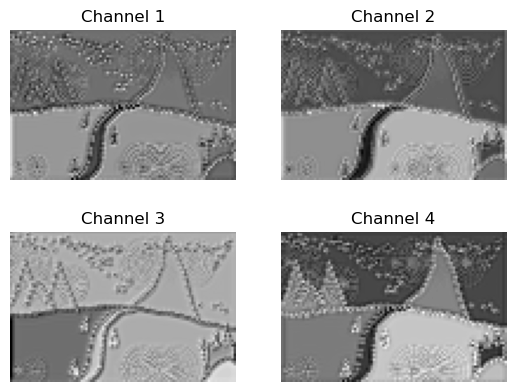

In [6]:
# Assuming latents is a tensor with shape (batch, latent_channels, width, height)
fig, axs = plt.subplots(2, 2)

# Plotting the four channels separately
for i, ax in enumerate(axs.flat):
    ax.imshow(latents[0, i].cpu().detach().numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title(f'Channel {i+1}')

plt.show()

Unet embedding

In [ ]:
print(pipe.unet)

In [7]:
latent = pipe(prompt=prompt, image=init_image, strength=0.75, guidance_scale=7.5, output_type='latent').images

100%|██████████| 37/37 [00:11<00:00,  3.36it/s]


In [16]:
latent.shape

torch.Size([1, 4, 64, 96])

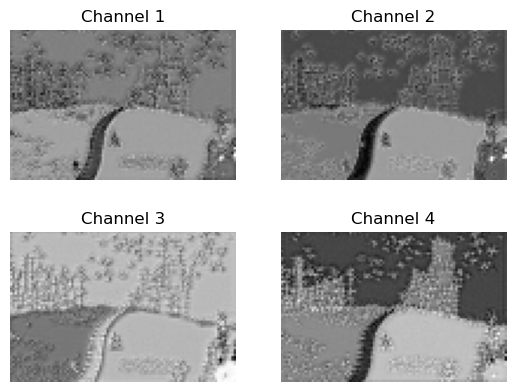

In [8]:
# Assuming latents is a tensor with shape (batch, latent_channels, width, height)
fig, axs = plt.subplots(2, 2)

# Plotting the four channels separately
for i, ax in enumerate(axs.flat):
    ax.imshow(latent[0, i].cpu().detach().numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title(f'Channel {i+1}')

plt.show()

This is the Unet output, before being decoded by VAE's decoder

AVA dataset downloader: https://github.com/ylogx/aesthetics (this dataset is now copyrighted)

### AADB

Alternative dataset from [this paper](https://arxiv.org/abs/1606.01621)

Download full resolution dataset from here: https://drive.usercontent.google.com/download?id=1Viswtzb77vqqaaICAQz9iuZ8OEYCu6-_&export=download&authuser=0

Description: https://ics.uci.edu/~skong2/aesthetics.html
- 10 000 images
- all of them are real photographies
- each image has been annoted manually by five workers with an overall esthetic score
- and eleven meaningful attributes: interesting content, object emphasis, good lightning, color harmony, vivid color, shallow depth of field, motion blur, rule of thirds, balancing element, repetition, symmetry

GitHub: https://github.com/aimerykong/deepImageAestheticsAnalysis

In [1]:
from datasets.utils import save_aadb

save_aadb()

In [16]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define the transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Define the dataset
dataset = ImageFolder(root='datasets/data', transform=transform)

# Define the dataloaders
batch_size = 32
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [19]:
dataset.targets

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


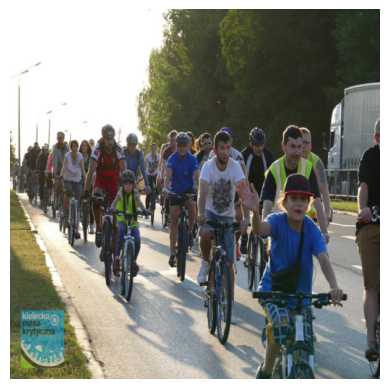

In [21]:
pil_image = transforms.ToPILImage()(dataset[1][0])

# Plot the PIL image
plt.imshow(pil_image)
plt.axis('off')
plt.show()